This notebook implements a complete machine learning pipeline for workout classification using sequential pose estimation data. The workflow includes:

1. Data preparation and preprocessing
2. Class imbalance handling with SMOTE
3. Feature scaling and label encoding
4. Sequence creation for time-series data
5. LSTM model with attention mechanism
6. Training with early stopping to prevent overfitting
7. Model evaluation using classification metrics
8. A prediction function for use with new data

The model architecture combines LSTM with attention mechanisms to effectively capture temporal patterns in workout movements and classify them accurately. Additional regularization techniques like dropout, batch normalization, and data augmentation (noise addition) help improve model robustness.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import random

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # Import F for dropout

In [2]:
try:
    from mediapipe_handler import MediaPipeHandler
    from get_work_out_labels import add_workout_label_back
except ImportError:
    print("Warning: mediapipe_handler or get_work_out_labels not found. Using dummy functions.")
    # Define dummy functions if the originals are not available
    class MediaPipeHandler:
        def read_csv_to_pd(self, path):
            print(f"Dummy reading: {path}")
            # Create a dummy dataframe structure similar to expected input
            # This will likely fail later steps if real data isn't loaded
            return pd.DataFrame({
                'label': [0, 1] * 10,
                'left_shoulder': [[0.1, 0.2, 0.3]] * 20,
                'right_shoulder': [[0.4, 0.5, 0.6]] * 20,
                'left_elbow': [[0.1, 0.2, 0.3]] * 20,
                'right_elbow': [[0.4, 0.5, 0.6]] * 20,
                'left_wrist': [[0.1, 0.2, 0.3]] * 20,
                'right_wrist': [[0.4, 0.5, 0.6]] * 20,
                'left_hip': [[0.1, 0.2, 0.3]] * 20,
                'right_hip': [[0.4, 0.5, 0.6]] * 20,
                'left_knee': [[0.1, 0.2, 0.3]] * 20,
                'right_knee': [[0.4, 0.5, 0.6]] * 20,
                'left_ankle': [[0.1, 0.2, 0.3]] * 20,
                'right_ankle': [[0.4, 0.5, 0.6]] * 20,
                'muscle group': [1, 2] * 10,
                'image': ['dummy_path'] * 20,
                'Unnamed: 0': range(20)
            })

    def add_workout_label_back(label_int):
        # Dummy mapping
        workout_map = { 0: "workout_a", 1: "workout_b" }
        return workout_map.get(label_int, "unknown")

2025-04-29 01:02:39.161984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-29 01:02:39.186036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-29 01:02:39.186085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 01:02:39.200821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 01:02:40.100680: W tensorflow/compiler/tf

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42) # Also set Python's random seed

In [7]:
# --- GPU setup ---
def get_device_info():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        current_device = torch.cuda.current_device()
        device_properties = torch.cuda.get_device_properties(current_device)
        print(f"GPU Device: {torch.cuda.get_device_name(current_device)}")
        print(f"GPU Memory: {device_properties.total_memory / 1e9:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        # Set device to highest memory capacity GPU if multiple are available
        if torch.cuda.device_count() > 1:
            print(f"Multiple GPUs available: {torch.cuda.device_count()}")
            max_mem = 0
            max_mem_device = 0
            for i in range(torch.cuda.device_count()):
                props = torch.cuda.get_device_properties(i)
                print(f"  GPU {i}: {props.name} ({props.total_memory / 1e9:.2f} GB)")
                if props.total_memory > max_mem:
                    max_mem = props.total_memory
                    max_mem_device = i
            torch.cuda.set_device(max_mem_device)
            print(f"Using GPU {max_mem_device} as primary device")
        print("CUDA is available! Training on GPU.")
    else:
        device = torch.device("cpu")
        print("WARNING: CUDA is not available. Training on CPU will be much slower!")
    return device

device = get_device_info()

# Enable cuDNN benchmarking for performance optimization if using GPU
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False # Set to False for potential speedup

GPU Device: Tesla T4
GPU Memory: 16.71 GB
CUDA Version: 12.6
CUDA is available! Training on GPU.


In [8]:
# --- File Paths and Setup ---
mediapipe_model = MediaPipeHandler()

# Define base data directory using a relative path
try:
    # Try script-style path resolution first
    script_dir = os.path.dirname(os.path.abspath(__file__))
    base_dir = os.path.dirname(script_dir)
except NameError:
    # If in an interactive environment (like Jupyter), use CWD's parent
    base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
    print(f"Running in interactive mode, assuming base directory: {base_dir}")


data_dir = os.path.join(base_dir, "data")
models_dir = os.path.join(data_dir, "models")

# Create models directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# Print paths for debugging
print(f"Base directory: {base_dir}")
print(f"Data directory: {data_dir}")
print(f"Models directory: {models_dir}")

current OS working directory is /home/jovyan/DesD_AI_pathway/AI/app
Running in interactive mode, assuming base directory: /home/jovyan/DesD_AI_pathway/AI
Base directory: /home/jovyan/DesD_AI_pathway/AI
Data directory: /home/jovyan/DesD_AI_pathway/AI/data
Models directory: /home/jovyan/DesD_AI_pathway/AI/data/models


I0000 00:00:1745888616.190280   13565 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1745888616.249457   13613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745888616.271656   13613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [9]:
# --- Load and Prepare Data ---
train_csv_path = os.path.join(data_dir, "train_new.csv")
test_csv_path = os.path.join(data_dir, "test_new.csv")
val_csv_path = os.path.join(data_dir, "validation_new.csv")

if not all(os.path.exists(p) for p in [train_csv_path, test_csv_path, val_csv_path]):
     print("Error: One or more CSV files not found. Please check paths:")
     print(f"Train: {train_csv_path} (Exists: {os.path.exists(train_csv_path)})")
     print(f"Test: {test_csv_path} (Exists: {os.path.exists(test_csv_path)})")
     print(f"Validation: {val_csv_path} (Exists: {os.path.exists(val_csv_path)})")
     # Exit or raise error if files are missing
     raise FileNotFoundError("Required CSV data files are missing.")

# Load full datasets (removed slicing)
print("Loading datasets...")
training_dataset = mediapipe_model.read_csv_to_pd(train_csv_path)
testing_dataset = mediapipe_model.read_csv_to_pd(test_csv_path)
validation_dataset = mediapipe_model.read_csv_to_pd(val_csv_path)
print(f"Loaded {len(training_dataset)} training samples.")
print(f"Loaded {len(testing_dataset)} testing samples.")
print(f"Loaded {len(validation_dataset)} validation samples.")

Loading datasets...
Loaded 69848 training samples.
Loaded 10032 testing samples.
Loaded 19544 validation samples.


Number of unique workout labels: 22
Workout labels: ['barbell bicep curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extensions', 'leg raises', 'plank', 'pull up', 'push ups', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


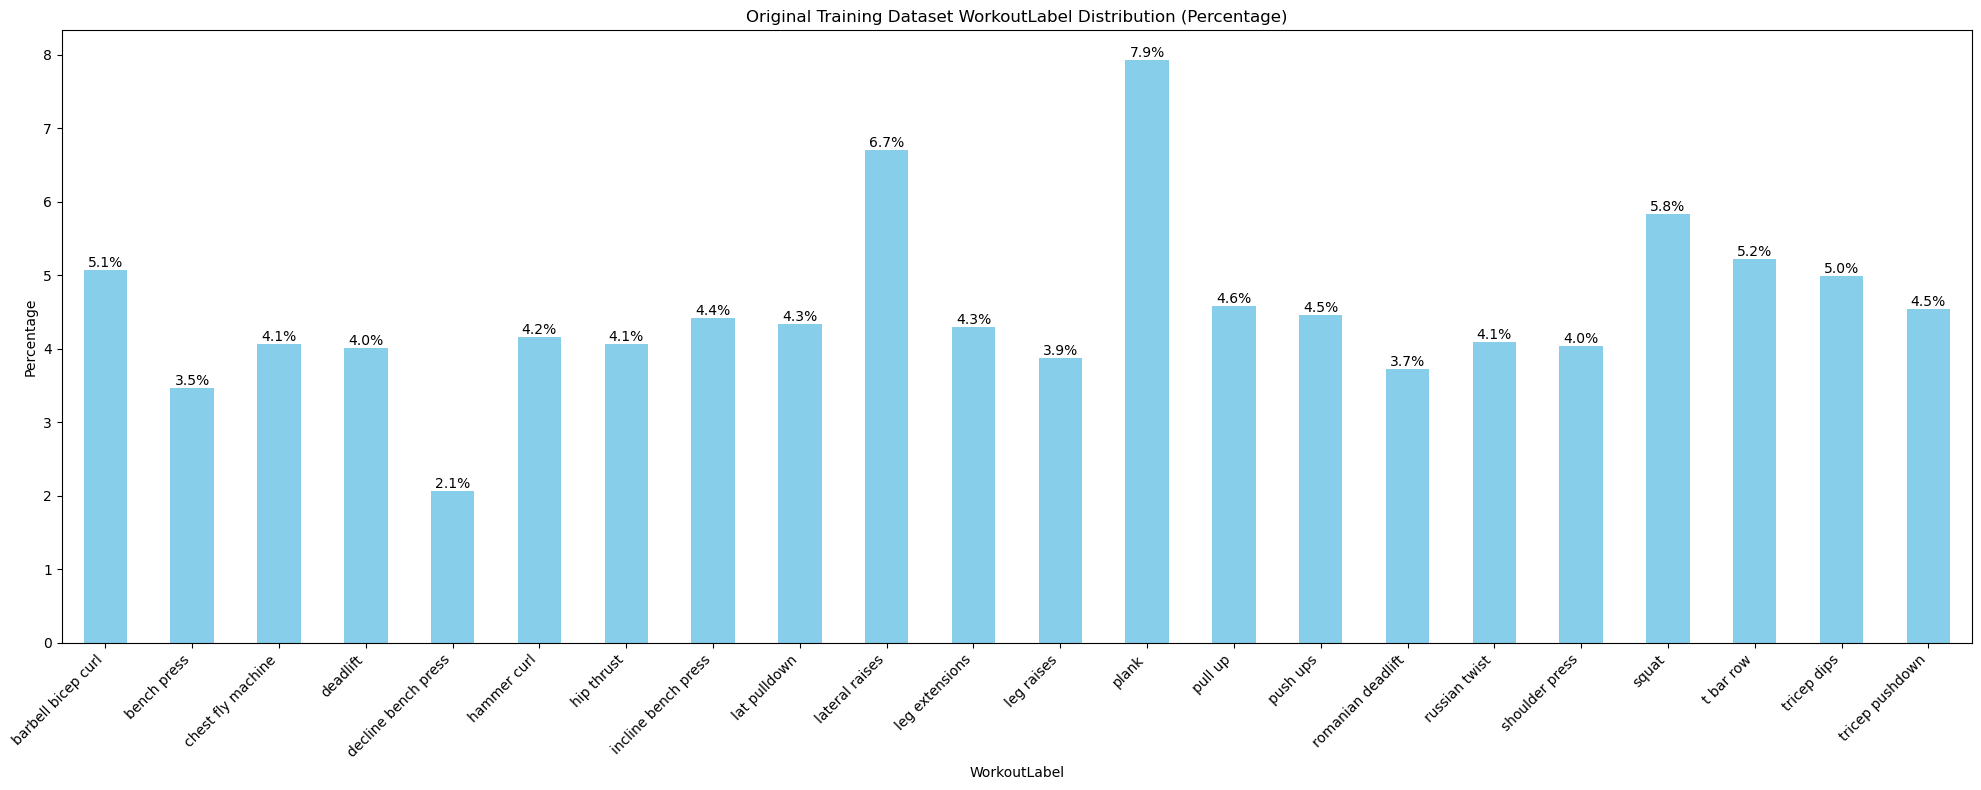

In [10]:
# Add workout labels
training_dataset['WorkoutLabel'] = training_dataset.apply(lambda x: add_workout_label_back(x['label']), axis=1)
testing_dataset['WorkoutLabel'] = testing_dataset.apply(lambda x: add_workout_label_back(x['label']), axis=1)
validation_dataset['WorkoutLabel'] = validation_dataset.apply(lambda x: add_workout_label_back(x['label']), axis=1)

# Get unique workout labels
Workout_labels = sorted(training_dataset['WorkoutLabel'].unique()) # Sort for consistency
print(f"Number of unique workout labels: {len(Workout_labels)}")
print(f"Workout labels: {Workout_labels}")

# Visualize class distribution (Original Training Data)
plt.figure(figsize=(20, 8))
value_counts = training_dataset['WorkoutLabel'].value_counts().sort_index() # Sort index for consistent bar order
percentages = value_counts / value_counts.sum() * 100

# Plot
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Original Training Dataset WorkoutLabel Distribution (Percentage)')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

In [11]:
# --- Preprocessing ---
# List of body keypoint features to preprocess
features_to_split = [
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

# Preprocessing function with improved logging for dropped columns
def preprocess_data(dataframe, columns_to_flatten):
    final_df = dataframe.copy()
    processed_cols = set() # Track columns successfully processed

    # Expanding each column into 3 separate columns (x, y, z)
    for column in columns_to_flatten:
        if column not in dataframe.columns:
             print(f"Warning: Column '{column}' not found in dataframe. Skipping.")
             continue
        try:
            # Convert string representations of arrays to actual arrays if needed
            if isinstance(dataframe[column].iloc[0], str):
                try:
                    # Attempt robust conversion using numpy's string parsing
                    final_df[column] = dataframe[column].apply(
                        lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x
                    )
                    # Check if conversion resulted in arrays of expected length (3)
                    if not all(isinstance(v, np.ndarray) and len(v) == 3 for v in final_df[column] if v is not None):
                         print(f"Warning: Conversion of column '{column}' did not consistently produce 3D arrays. Reverting.")
                         final_df[column] = dataframe[column] # Revert if conversion failed
                    else:
                         print(f"Successfully converted string arrays in column '{column}'")
                except Exception as e_conv:
                    print(f"Warning: Could not convert column '{column}' from string to array using np.fromstring: {e_conv}. Trying eval.")
                    try:
                        final_df[column] = dataframe[column].apply(
                            lambda x: np.array(eval(x)) if isinstance(x, str) else x
                        )
                        print(f"Successfully converted string arrays in column '{column}' using eval.")
                    except Exception as e_eval:
                         print(f"Error: Failed to convert column '{column}' from string using eval: {e_eval}. Skipping expansion.")
                         continue # Skip expansion if conversion fails

            # Ensure the column contains numpy arrays before stacking
            # Handle potential None values if necessary
            valid_values = [v for v in final_df[column] if v is not None]
            if not all(isinstance(v, np.ndarray) for v in valid_values):
                print(f"Warning: Column '{column}' does not contain consistent numpy arrays after conversion attempts. Skipping expansion.")
                continue

            # Filter out None before stacking if they exist
            if final_df[column].isnull().any():
                print(f"Warning: Column '{column}' contains None values. These rows will be excluded from expansion.")
                not_null_indices = final_df[column].notnull()
                expanded_df = pd.DataFrame(
                    np.vstack(final_df.loc[not_null_indices, column].values).astype(float),
                    columns=[f'{column}_x', f'{column}_y', f'{column}_z'],
                    index=final_df.index[not_null_indices]
                )
            else:
                 # Now expand the arrays into separate columns
                expanded_df = pd.DataFrame(
                    np.vstack(final_df[column].values).astype(float), # Use .values for efficiency
                    columns=[f'{column}_x', f'{column}_y', f'{column}_z'],
                    index=final_df.index
                )

            # Use combine_first or join for safer merging
            final_df = final_df.join(expanded_df)
            processed_cols.update(expanded_df.columns)
            # Drop the original column *after* successful expansion
            final_df = final_df.drop(column, axis=1)

        except Exception as e:
            print(f"Error processing column '{column}' during expansion: {e}")
            print(f"Sample value: {dataframe[column].iloc[0]}")
            # Do not drop the original column if expansion failed

    # Clean numeric columns only - skip label/metadata columns
    columns_to_skip = ['label', 'WorkoutLabel', 'muscle group', 'image', 'Unnamed: 0']
    cols_to_drop = []
    for col in final_df.columns:
        if col in columns_to_skip or col in processed_cols:
            continue

        # Attempt conversion to numeric, identify problematic columns
        try:
            # Use pd.to_numeric with errors='coerce' to handle non-convertible values gracefully
            final_df[col] = pd.to_numeric(final_df[col], errors='coerce')
            if final_df[col].isnull().any():
                print(f"Info: Column '{col}' contained non-numeric values which were converted to NaN.")
                # Decide how to handle NaNs, e.g., fill or drop
                # Option 1: Fill with 0 (or mean/median)
                # final_df[col].fillna(0, inplace=True)
                # Option 2: Mark for dropping if too many NaNs or critical feature
                if final_df[col].isnull().sum() > 0.1 * len(final_df): # Example threshold
                    print(f"-> Marking column '{col}' for removal due to high NaN count after conversion.")
                    cols_to_drop.append(col)

        except (ValueError, TypeError): # Should be less likely with errors='coerce'
            print(f"Info: Column '{col}' could not be processed by pd.to_numeric.")
            # Check if it was one of the original features_to_split that failed expansion
            if col in columns_to_flatten:
                 print(f"-> Marking original feature column '{col}' for removal due to failed expansion/conversion.")
                 cols_to_drop.append(col)
            # Check for other unexpected non-numeric columns (e.g., leftover strings)
            elif final_df[col].dtype == 'object':
                 print(f"-> Marking unexpected object column '{col}' for removal.")
                 cols_to_drop.append(col)

    if cols_to_drop:
        print(f"Dropping columns due to failed conversion or processing: {list(set(cols_to_drop))}") # Use set to avoid duplicates
        final_df = final_df.drop(columns=list(set(cols_to_drop)))

    # Handle potential NaNs introduced by coercion or joins
    numeric_cols = final_df.select_dtypes(include=np.number).columns
    if final_df[numeric_cols].isnull().any().any():
        print("Warning: NaNs detected in numeric columns after preprocessing. Filling with 0.")
        final_df[numeric_cols] = final_df[numeric_cols].fillna(0)


    return final_df

# Function to separate features (X) and labels (y)
def return_X_y(dataframe, label_col='label', cols_to_drop=None):
    """Separates features and the target label."""
    if cols_to_drop is None:
        # Default columns to drop if not specified
        cols_to_drop = ['label', 'muscle group', 'WorkoutLabel', 'image', 'Unnamed: 0']

    # Ensure label_col is in the dataframe
    if label_col not in dataframe.columns:
        raise ValueError(f"Label column '{label_col}' not found in dataframe.")

    # Identify feature columns (numeric types) excluding the drop list and label
    feature_cols = [col for col in dataframe.select_dtypes(include=np.number).columns
                    if col != label_col and col not in cols_to_drop]

    if not feature_cols:
         raise ValueError("No numeric feature columns found after preprocessing and filtering.")

    X = dataframe[feature_cols]
    y = dataframe[label_col]

    print(f"Selected {len(X.columns)} features.")
    # print(f"Feature columns: {X.columns.tolist()}") # Uncomment for debugging
    return X, y

# Process datasets
print("\nPreprocessing Training Data...")
training_dataset_preprocessed = preprocess_data(training_dataset, features_to_split)
X_train, y_train = return_X_y(training_dataset_preprocessed)

print("\nPreprocessing Testing Data...")
testing_dataset_preprocessed = preprocess_data(testing_dataset, features_to_split)
X_test, y_test = return_X_y(testing_dataset_preprocessed)

print("\nPreprocessing Validation Data...")
validation_dataset_preprocessed = preprocess_data(validation_dataset, features_to_split)
X_validation, y_validation = return_X_y(validation_dataset_preprocessed)


Preprocessing Training Data...
Info: Column 'left_pinky' contained non-numeric values which were converted to NaN.
-> Marking column 'left_pinky' for removal due to high NaN count after conversion.
Info: Column 'right_pinky' contained non-numeric values which were converted to NaN.
-> Marking column 'right_pinky' for removal due to high NaN count after conversion.
Info: Column 'left_index' contained non-numeric values which were converted to NaN.
-> Marking column 'left_index' for removal due to high NaN count after conversion.
Info: Column 'right_index' contained non-numeric values which were converted to NaN.
-> Marking column 'right_index' for removal due to high NaN count after conversion.
Info: Column 'left_thumb' contained non-numeric values which were converted to NaN.
-> Marking column 'left_thumb' for removal due to high NaN count after conversion.
Info: Column 'right_thumb' contained non-numeric values which were converted to NaN.
-> Marking column 'right_thumb' for removal 


Applying SMOTE to Training Data ONLY...
SMOTE applied successfully to training data.
Original training shape: (69848, 36), Balanced training shape: (121968, 36)


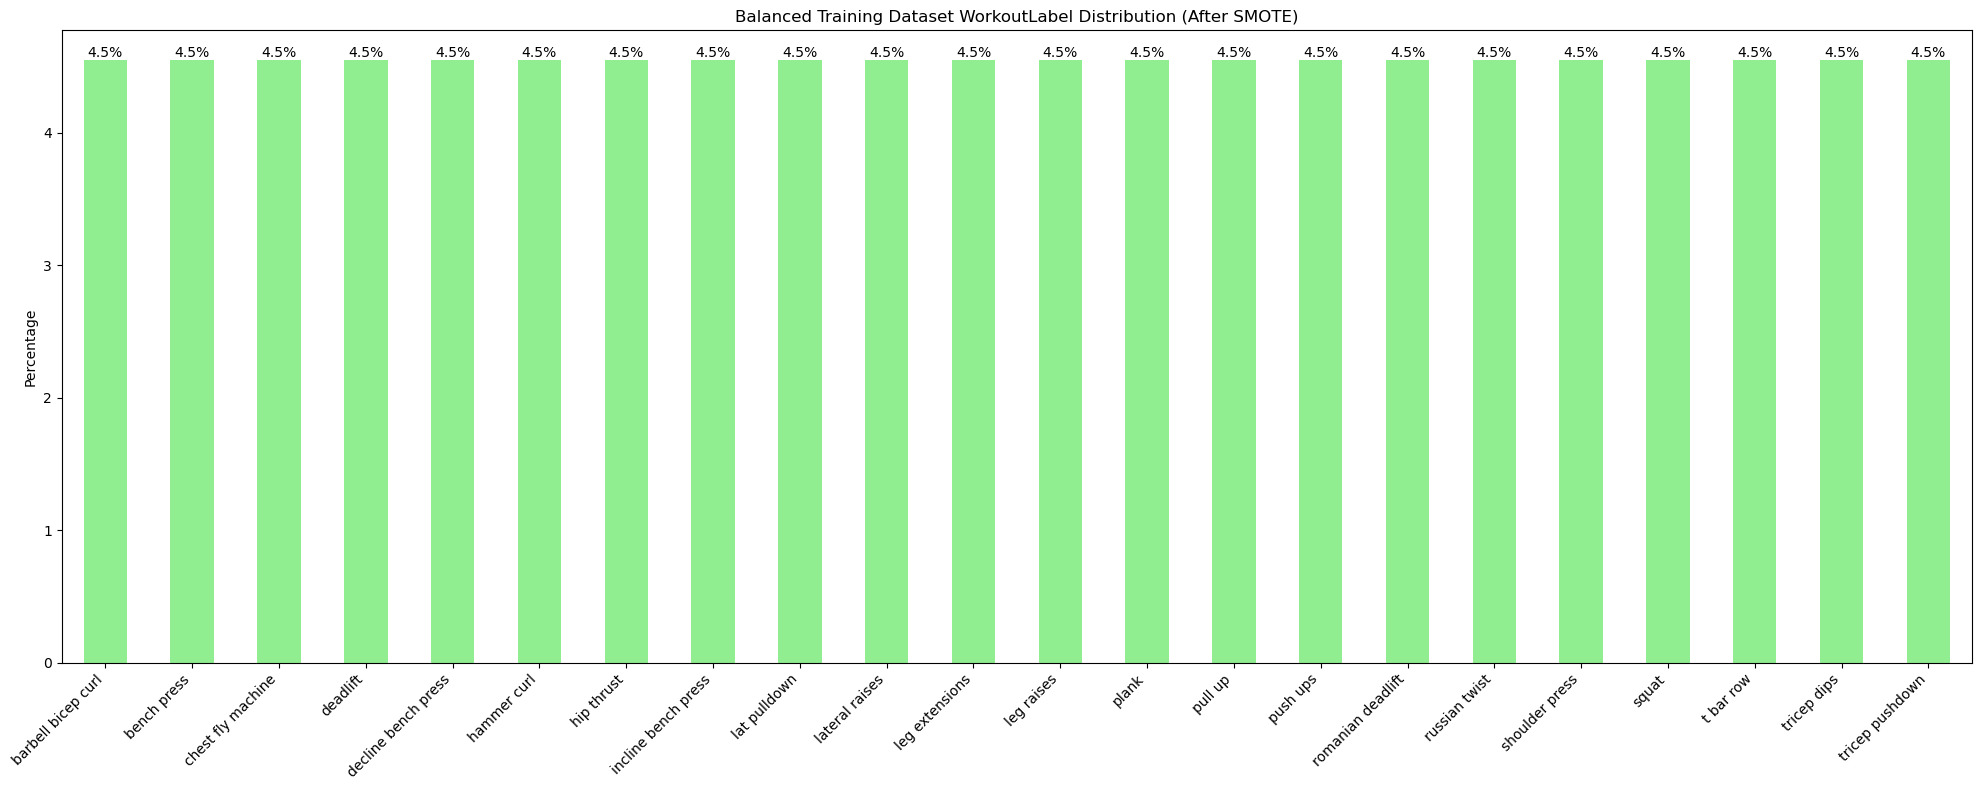

In [12]:
# --- SMOTE Application (Corrected) ---
print("\nApplying SMOTE to Training Data ONLY...")
smote = SMOTE(random_state=42, k_neighbors=5) # k_neighbors=5 is default, adjust if needed
try:
    # Check minimum class size before applying SMOTE
    min_class_size = y_train.value_counts().min()
    if min_class_size < smote.k_neighbors:
         print(f"Warning: Minimum class size ({min_class_size}) is less than k_neighbors ({smote.k_neighbors}). Adjusting k_neighbors.")
         smote.k_neighbors = max(1, min_class_size - 1) # Adjust k_neighbors

    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print("SMOTE applied successfully to training data.")
    print(f"Original training shape: {X_train.shape}, Balanced training shape: {X_train_balanced.shape}")

    # Visualize class distribution AFTER SMOTE
    plt.figure(figsize=(20, 8))
    balanced_labels = [add_workout_label_back(l) for l in y_train_balanced]
    value_counts_balanced = pd.Series(balanced_labels).value_counts().sort_index()
    percentages_balanced = value_counts_balanced / value_counts_balanced.sum() * 100

    ax_balanced = percentages_balanced.plot(kind='bar', color='lightgreen')
    for p in ax_balanced.patches:
        ax_balanced.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
    plt.title('Balanced Training Dataset WorkoutLabel Distribution (After SMOTE)')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

except ValueError as e:
     print(f"Error during SMOTE: {e}")
     print("Proceeding without SMOTE balancing.")
     X_train_balanced, y_train_balanced = X_train.copy(), y_train.copy() # Use original data

In [13]:
# --- Feature Scaling ---
print("\nScaling features...")
scaler = StandardScaler()
# Fit scaler ONLY on the (potentially balanced) training data
X_train_scaled = scaler.fit_transform(X_train_balanced)
# Transform validation and test sets using the SAME scaler
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)
print("Features scaled.")

# Save the scaler
scaler_path = os.path.join(models_dir, "feature_scaler.pkl")
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")


Scaling features...
Features scaled.
Scaler saved to /home/jovyan/DesD_AI_pathway/AI/data/models/feature_scaler.pkl


In [14]:
# --- Label Encoding ---
print("\nEncoding labels...")
label_encoder = LabelEncoder()
# Fit encoder on the balanced training labels to ensure all classes are known
# Combine all labels to ensure encoder knows all possible classes across splits
all_labels_combined = pd.concat([y_train_balanced, y_validation, y_test], ignore_index=True)
label_encoder.fit(all_labels_combined)


# Encode all sets using the fitted encoder
y_train_encoded = label_encoder.transform(y_train_balanced)
y_validation_encoded = label_encoder.transform(y_validation) # Use original validation labels
y_test_encoded = label_encoder.transform(y_test)       # Use original test labels
print("Labels encoded.")
print(f"Encoded classes: {label_encoder.classes_}") # These are the integer representations
print(f"Original class names: {label_encoder.inverse_transform(label_encoder.classes_)}") # Map back to names

# Save the label encoder
encoder_path = os.path.join(models_dir, "label_encoder.pkl")
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"Label encoder saved to {encoder_path}")


Encoding labels...
Labels encoded.
Encoded classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Original class names: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label encoder saved to /home/jovyan/DesD_AI_pathway/AI/data/models/label_encoder.pkl


In [15]:
# --- Sequence Creation (Corrected) ---
def create_sequences(features, labels, sequence_length=10, overlap_ratio=0.5):
    """ Groups features into sequences, ensuring sequences belong to the same label class. """
    sequences = []
    sequence_labels = []
    unique_labels = np.unique(labels)

    print(f"  Creating sequences with length {sequence_length}, overlap {overlap_ratio*100}%...")
    total_sequences = 0
    skipped_labels = 0

    for label_class in unique_labels:
        # Find indices for the current class
        indices = np.where(labels == label_class)[0]

        if len(indices) < sequence_length:
             # print(f"  Skipping label {label_class}: Not enough samples ({len(indices)}) for sequence length {sequence_length}")
             skipped_labels += 1
             continue # Skip if not enough data for even one sequence

        # Calculate step size based on overlap
        step_size = max(1, int(sequence_length * (1 - overlap_ratio)))

        class_sequences = 0
        # Create sequences with specified overlap
        for i in range(0, len(indices) - sequence_length + 1, step_size):
            seq_indices = indices[i : i + sequence_length]

            # Double-check sequence length (should always be true here)
            if len(seq_indices) == sequence_length:
                sequences.append(features[seq_indices])
                sequence_labels.append(label_class)
                class_sequences += 1

        # print(f"  Label {label_class}: Created {class_sequences} sequences.")
        total_sequences += class_sequences

    print(f"  Finished creating sequences. Total sequences: {total_sequences}. Skipped {skipped_labels} labels due to insufficient length.")

    if not sequences: # Handle case where no sequences could be created
        print("Warning: No sequences were created. Check sequence_length and data availability.")
        # Return empty arrays with correct dimensions
        feature_dim = features.shape[1] if features.ndim > 1 else 1
        return np.empty((0, sequence_length, feature_dim)), np.empty((0,))

    return np.array(sequences), np.array(sequence_labels)

# Define sequence parameters
SEQUENCE_LENGTH = 10
OVERLAP_RATIO = 0.5

print("\nCreating sequences from data...")
print("Processing Training Set:")
X_train_seq, y_train_seq = create_sequences(
    X_train_scaled, y_train_encoded, # Use balanced, scaled train data
    sequence_length=SEQUENCE_LENGTH,
    overlap_ratio=OVERLAP_RATIO
)
print("Processing Validation Set:")
X_val_seq, y_val_seq = create_sequences(
    X_validation_scaled, y_validation_encoded, # Use ORIGINAL, scaled validation data
    sequence_length=SEQUENCE_LENGTH,
    overlap_ratio=OVERLAP_RATIO
)
print("Processing Test Set:")
X_test_seq, y_test_seq = create_sequences(
    X_test_scaled, y_test_encoded, # Use ORIGINAL, scaled test data
    sequence_length=SEQUENCE_LENGTH,
    overlap_ratio=OVERLAP_RATIO
)


Creating sequences from data...
Processing Training Set:
  Creating sequences with length 10, overlap 50.0%...
  Finished creating sequences. Total sequences: 24354. Skipped 0 labels due to insufficient length.
Processing Validation Set:
  Creating sequences with length 10, overlap 50.0%...
  Finished creating sequences. Total sequences: 3876. Skipped 0 labels due to insufficient length.
Processing Test Set:
  Creating sequences with length 10, overlap 50.0%...
  Finished creating sequences. Total sequences: 1974. Skipped 0 labels due to insufficient length.


In [16]:
# Shuffle sequences (important after grouping by label)
# Use different seeds for reproducibility if needed, but shuffling is key
np.random.seed(42)
train_indices = np.random.permutation(len(X_train_seq))
X_train_seq = X_train_seq[train_indices]
y_train_seq = y_train_seq[train_indices]

np.random.seed(43) # Use different seed for validation shuffle
val_indices = np.random.permutation(len(X_val_seq))
X_val_seq = X_val_seq[val_indices]
y_val_seq = y_val_seq[val_indices]

# Test set doesn't strictly need shuffling for evaluation, but can be done
np.random.seed(44)
test_indices = np.random.permutation(len(X_test_seq))
X_test_seq = X_test_seq[test_indices]
y_test_seq = y_test_seq[test_indices]

print(f"\nFinal sequence data shapes:")
print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"X_val_seq: {X_val_seq.shape}, y_val_seq: {y_val_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")


Final sequence data shapes:
X_train_seq: (24354, 10, 36), y_train_seq: (24354,)
X_val_seq: (3876, 10, 36), y_val_seq: (3876,)
X_test_seq: (1974, 10, 36), y_test_seq: (1974,)


In [17]:
# --- PyTorch Dataset and DataLoader ---
class WorkoutSequenceDataset(Dataset):
    def __init__(self, features, labels, add_noise=False, noise_level=0.05):
        """ Dataset for sequential workout data """
        if not isinstance(features, np.ndarray) or not isinstance(labels, np.ndarray):
             raise TypeError("Features and labels must be numpy arrays")
        # Check for empty features/labels before accessing shape
        if features.size == 0 or labels.size == 0:
             print("Warning: Initializing WorkoutSequenceDataset with empty features or labels.")
             self.features = torch.FloatTensor([])
             self.labels = torch.LongTensor([])
        elif features.shape[0] != labels.shape[0]:
             raise ValueError(f"Number of feature sequences ({features.shape[0]}) must match number of labels ({labels.shape[0]})")
        else:
            self.features = torch.FloatTensor(features)
            self.labels = torch.LongTensor(labels)

        self.add_noise = add_noise
        self.noise_level = noise_level

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if idx >= len(self.labels):
             raise IndexError("Index out of bounds")
        x = self.features[idx]
        y = self.labels[idx]

        # Add Gaussian noise during training for robustness
        if self.add_noise and self.noise_level > 0:
            noise = torch.randn_like(x) * self.noise_level
            x = x + noise

        return x, y

# Create sequence datasets
# Use a moderate noise level for regularization
train_dataset = WorkoutSequenceDataset(X_train_seq, y_train_seq, add_noise=True, noise_level=0.1)
val_dataset = WorkoutSequenceDataset(X_val_seq, y_val_seq, add_noise=False) # No noise for validation
test_dataset = WorkoutSequenceDataset(X_test_seq, y_test_seq, add_noise=False) # No noise for testing

# Create dataloaders
batch_size = 64 # Can potentially increase batch size depending on GPU memory
# Use num_workers > 0 only if not on Windows or if using appropriate multiprocessing start method
num_workers = min(4, os.cpu_count()) if os.name != 'nt' else 0
print(f"Using num_workers={num_workers} for DataLoaders.")

# Handle empty datasets in DataLoader creation
if len(train_dataset) > 0:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False, drop_last=True) # drop_last can help with BatchNorm issues if last batch is size 1
else:
    print("Warning: Training dataset is empty. Cannot create DataLoader.")
    train_loader = None

if len(val_dataset) > 0:
    val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False) # Larger batch size for validation/test
else:
    print("Warning: Validation dataset is empty. Cannot create DataLoader.")
    val_loader = None

if len(test_dataset) > 0:
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_workers, pin_memory=True if device.type == 'cuda' else False)
else:
    print("Warning: Test dataset is empty. Cannot create DataLoader.")
    test_loader = None

if train_loader:
    print(f"\nCreated DataLoaders with batch size {batch_size} (train) and {batch_size*2} (val/test).")
else:
    print("\nCould not create DataLoaders due to empty dataset(s).")

Using num_workers=4 for DataLoaders.

Created DataLoaders with batch size 64 (train) and 128 (val/test).


In [18]:
# --- LSTM Model Definition ---
class LSTMWorkoutClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(LSTMWorkoutClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=False) # Consider bidirectional=True

        # Attention mechanism (optional but often helpful)
        # If bidirectional, input to attention should be hidden_size * 2
        attention_input_dim = hidden_size # * 2 if bidirectional else hidden_size
        self.attention = nn.Sequential(
            nn.Linear(attention_input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1) # Apply softmax over the sequence dimension
        )

        # Dropout after LSTM/Attention
        self.feature_dropout = nn.Dropout(dropout + 0.1) # Slightly higher dropout on features

        # Fully connected layers
        self.fc1 = nn.Linear(attention_input_dim, 128) # Match attention output dim
        self.relu = nn.ReLU()
        # Apply BatchNorm before activation for potential stability benefits
        self.batch_norm = nn.BatchNorm1d(128) # BatchNorm after linear
        self.fc_dropout = nn.Dropout(dropout + 0.2) # Higher dropout before final layer
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: [batch_size, sequence_length, features]
        batch_size, seq_len, _ = x.size()

        # Input dropout (can help regularize)
        # x = F.dropout(x, p=0.1, training=self.training) # Optional input dropout

        # Initialize hidden state (and cell state)
        # If bidirectional, h0/c0 shape is (num_layers * 2, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # Forward propagate LSTM
        # lstm_out shape: [batch_size, seq_len, num_directions * hidden_size]
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Apply attention mechanism
        # attention_weights shape: [batch_size, seq_len, 1]
        attention_weights = self.attention(lstm_out)
        # context_vector shape: [batch_size, num_directions * hidden_size]
        context_vector = torch.sum(attention_weights * lstm_out, dim=1) # Weighted sum across sequence

        # Apply dropout to the context vector
        context_vector = self.feature_dropout(context_vector)

        # Dense layers
        out = self.fc1(context_vector)
        # Apply BatchNorm before ReLU
        # Ensure BatchNorm is applied only if batch size > 1 during training
        if self.batch_norm.num_features == out.shape[1] and out.shape[0] > 1:
             out = self.batch_norm(out)
        elif out.shape[0] <= 1 and self.training:
             # Skip BatchNorm if batch size is 1 during training
             pass
        elif not self.training:
             # Apply BatchNorm during eval even if batch size is 1 (uses running stats)
             if self.batch_norm.num_features == out.shape[1]:
                  out = self.batch_norm(out)

        out = self.relu(out)
        out = self.fc_dropout(out)
        out = self.fc2(out)

        return out

In [19]:
# Define model parameters
# Ensure input_size matches the number of features after preprocessing
if 'X_train_scaled' in locals() and X_train_scaled.shape and X_train_scaled.ndim == 2:
     input_size = X_train_scaled.shape[1]
elif 'X_train' in locals() and X_train.shape and X_train.ndim == 2:
     input_size = X_train.shape[1] # Fallback if scaling failed
else:
     input_size = 36 # Default guess if data loading failed
     print(f"Warning: Could not determine input size from data. Using default: {input_size}")

hidden_size = 128
num_layers = 2
num_classes = len(label_encoder.classes_)
dropout_rate = 0.4 # Adjusted dropout rate

# Initialize model
model = LSTMWorkoutClassifier(input_size, hidden_size, num_layers, num_classes, dropout_rate)
model = model.to(device)
print("\nModel Architecture:")
print(model)
print(f"Input size: {input_size}, Hidden size: {hidden_size}, Num layers: {num_layers}, Num classes: {num_classes}, Dropout: {dropout_rate}")



Model Architecture:
LSTMWorkoutClassifier(
  (lstm): LSTM(36, 128, num_layers=2, batch_first=True, dropout=0.4)
  (attention): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Softmax(dim=1)
  )
  (feature_dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_dropout): Dropout(p=0.6000000000000001, inplace=False)
  (fc2): Linear(in_features=128, out_features=22, bias=True)
)
Input size: 36, Hidden size: 128, Num layers: 2, Num classes: 22, Dropout: 0.4



Validating data separation (simple check)...
  Simple validation check passed (no exact matches found in first batches).
  Note: This is a basic check and doesn't guarantee perfect separation, especially with overlapping sequences.
Emptying CUDA cache before training...

--- Starting Training (Max Epochs: 50, Patience: 10) ---
Epoch 1/50 | Train Loss: 1.1227 | Val Loss: 0.2367 | Train Acc: 0.6932 | Val Acc: 0.9267 | Gap: -0.2335 | LR: 1.0e-03
  Validation loss improved to 0.2367. Saving model state.
Epoch 2/50 | Train Loss: 0.1877 | Val Loss: 0.1454 | Train Acc: 0.9582 | Val Acc: 0.9577 | Gap: 0.0005 | LR: 1.0e-03
  Validation loss improved to 0.1454. Saving model state.
Epoch 3/50 | Train Loss: 0.0787 | Val Loss: 0.1279 | Train Acc: 0.9837 | Val Acc: 0.9685 | Gap: 0.0152 | LR: 1.0e-03
  Validation loss improved to 0.1279. Saving model state.
Epoch 4/50 | Train Loss: 0.0458 | Val Loss: 0.1015 | Train Acc: 0.9905 | Val Acc: 0.9807 | Gap: 0.0099 | LR: 1.0e-03
  Validation loss improved 

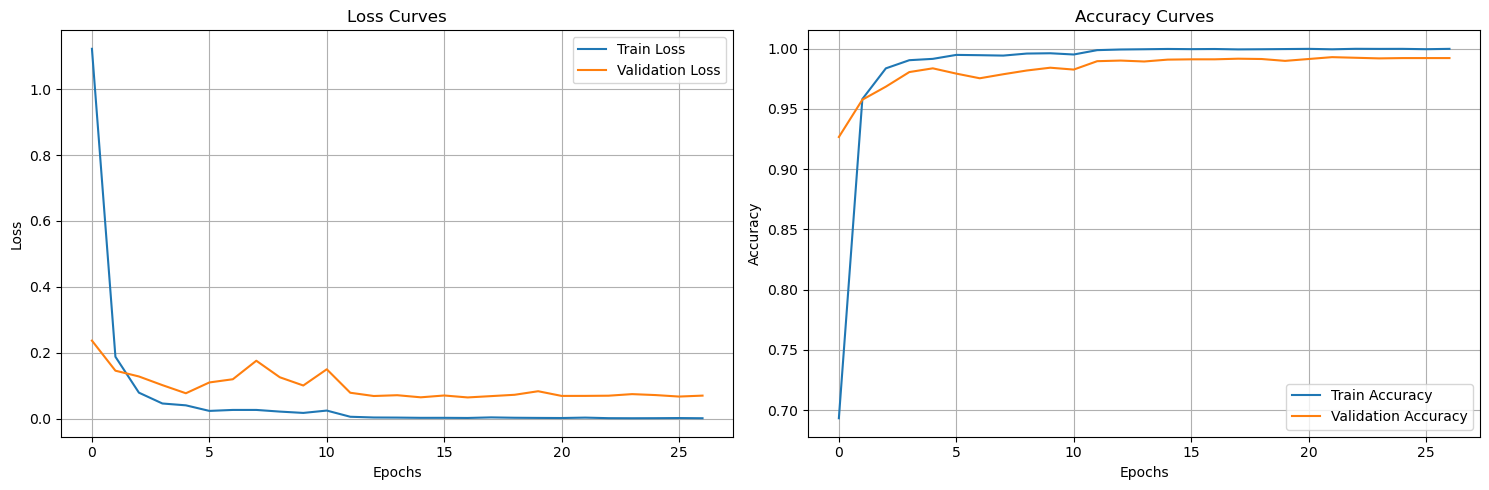

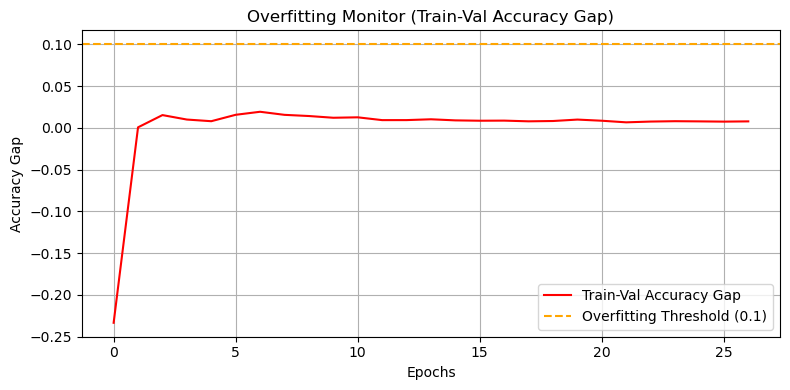

Loading best model state for final evaluation.

Model saved to /home/jovyan/DesD_AI_pathway/AI/data/models/lstm_workout_classifier_sequential_v2.pth


In [20]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss() # Standard for multi-class classification
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) # AdamW often preferred over Adam
# FIX: Remove the 'verbose' argument as it's deprecated/removed in newer PyTorch versions
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5) # Adjust patience/factor

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=7):
    # Check if dataloaders are valid
    if train_loader is None or val_loader is None:
        print("Error: Training or validation DataLoader is None. Cannot train.")
        return model # Return untrained model

    if device.type == 'cuda':
        print("Emptying CUDA cache before training...")
        torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    overfitting_threshold = 0.10 # Warn if train-val accuracy gap exceeds 10%

    print(f"\n--- Starting Training (Max Epochs: {num_epochs}, Patience: {patience}) ---")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # L1 regularization (optional, AdamW's weight decay handles L2)
            # l1_lambda = 1e-5
            # l1_norm = sum(p.abs().sum() for p in model.parameters())
            # loss = loss + l1_lambda * l1_norm

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())

            # Optional: Print progress within epoch
            # if (i + 1) % 100 == 0:
            #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(train_true, train_preds)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Handle potentially empty validation set
        if len(val_loader.dataset) == 0:
             print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: N/A (empty set) | Val Acc: N/A")
             # Cannot perform validation steps like LR scheduling or early stopping
             continue # Move to next epoch

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(epoch_val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < current_lr:
             print(f"  Learning rate reduced to {new_lr:.1e}")


        # Print statistics
        accuracy_gap = train_accuracy - val_accuracy
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | '
              f'Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f} | Gap: {accuracy_gap:.4f} | LR: {current_lr:.1e}')

        # Monitor for overfitting
        if accuracy_gap > overfitting_threshold:
            print(f"  WARNING: Potential overfitting! Accuracy Gap ({accuracy_gap:.4f}) > Threshold ({overfitting_threshold:.2f})")

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            # Save model state immediately when improved
            best_model_state = model.state_dict()
            print(f"  Validation loss improved to {best_val_loss:.4f}. Saving model state.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print(f'--- Early stopping triggered after {epoch+1} epochs. ---')
                if best_model_state:
                     print("Restoring best model weights.")
                     model.load_state_dict(best_model_state)
                else:
                     print("Warning: Early stopping triggered but no best model state was saved.")
                break # Exit training loop

    print("--- Training Finished ---")

    # Plot training curves (only if data exists)
    if train_losses and val_losses:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curves')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curves')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Plot accuracy gap
        plt.figure(figsize=(8, 4))
        accuracy_gaps = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]
        plt.plot(accuracy_gaps, label='Train-Val Accuracy Gap', color='red')
        plt.axhline(y=overfitting_threshold, color='orange', linestyle='--', label=f'Overfitting Threshold ({overfitting_threshold})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy Gap')
        plt.title('Overfitting Monitor (Train-Val Accuracy Gap)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping plotting curves as training/validation data was insufficient.")


    # Load best model state if early stopping occurred and state was saved
    if epochs_no_improve >= patience and best_model_state:
        print("Loading best model state for final evaluation.")
        model.load_state_dict(best_model_state)

    return model


# --- Data Separation Validation (Simple Check) ---
def validate_data_separation(train_loader, val_loader):
    """ Basic check for exact sequence matches between train and val sets. """
    print("\nValidating data separation (simple check)...")
    # Check if loaders are valid before iterating
    if train_loader is None or val_loader is None:
         print("  Skipping validation check: Train or Validation DataLoader is None.")
         return True # Allow proceeding but with caution

    try:
        train_batch_iter = iter(train_loader)
        val_batch_iter = iter(val_loader)
        train_batch = next(train_batch_iter)[0]
        val_batch = next(val_batch_iter)[0]

        # Check a few samples from the first batch
        for i in range(min(5, train_batch.size(0))):
            train_sample = train_batch[i].cpu().numpy()
            for j in range(min(5, val_batch.size(0))):
                val_sample = val_batch[j].cpu().numpy()
                if np.allclose(train_sample, val_sample, atol=1e-5): # Use tolerance for float comparison
                    print(f"  WARNING: Potential data leakage! Train sample {i} is very close to Validation sample {j}.")
                    # Consider returning False or raising an error if strict separation is critical
                    # return False
        print("  Simple validation check passed (no exact matches found in first batches).")
        print("  Note: This is a basic check and doesn't guarantee perfect separation, especially with overlapping sequences.")
        return True
    except StopIteration:
         print("  Warning: Could not retrieve batches for validation check (dataset might be empty).")
         return True # Allow proceeding but with caution
    except Exception as e:
         print(f"  Error during validation check: {e}")
         return True # Allow proceeding but with caution


# Validate before training and ensure loaders exist
if train_loader and val_loader and validate_data_separation(train_loader, val_loader):
    # Train the model
    model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10) # Increased epochs/patience

    # Save the final (potentially best) model
    model_path = os.path.join(models_dir, "lstm_workout_classifier_sequential_v2.pth")
    # Ensure label_encoder is fitted before accessing classes_
    if hasattr(label_encoder, 'classes_'):
        label_classes_list = label_encoder.classes_.tolist()
    else:
        print("Warning: Label encoder not fitted, cannot save class names.")
        label_classes_list = []

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'num_classes': num_classes,
        'dropout_rate': dropout_rate,
        'sequence_length': SEQUENCE_LENGTH,
        'scaler_path': scaler_path, # Store path to scaler
        'encoder_path': encoder_path, # Store path to encoder
        'label_classes': label_classes_list # Store class names
    }, model_path)
    print(f"\nModel saved to {model_path}")

elif not train_loader or not val_loader:
     print("\nTraining aborted: Training or Validation DataLoader could not be created (likely due to empty datasets after sequencing).")
else: # leakage detected
    print("\nTraining aborted due to potential data leakage detected by validation check.")



===== Evaluating on Test Set =====
Test Loss: 0.0017
Test Accuracy: 0.9995 (99.95%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00        85
           3       1.00      1.00      1.00        79
           4       1.00      1.00      1.00        35
           5       0.99      1.00      0.99        83
           6       1.00      1.00      1.00        82
           7       1.00      1.00      1.00        91
           8       1.00      1.00      1.00        83
           9       1.00      1.00      1.00       133
          10       1.00      1.00      1.00        85
          11       1.00      1.00      1.00        80
          12       1.00      1.00      1.00       157
          13       1.00      1.00      1.00        88
          14       1.00      1.00      1.00        93
          15  

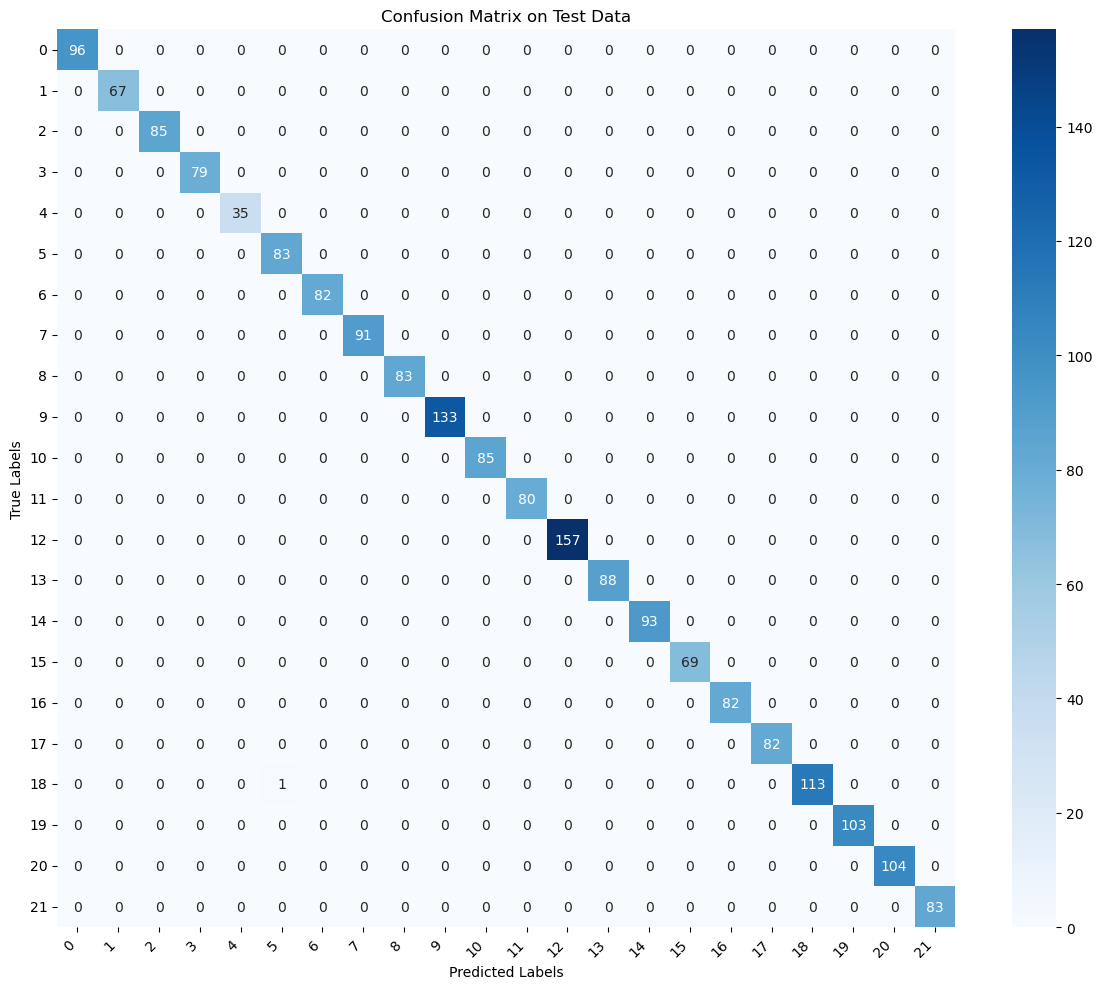


===== Evaluating on Validation Set =====
Validation Loss: 0.0697
Validation Accuracy: 0.9923 (99.23%)

===== Model Training and Evaluation Complete =====


In [21]:
# --- Evaluation ---
def evaluate_model(model, data_loader, label_encoder, criterion, device):
    """ Evaluates the model on a given dataset. """
    # Check if dataloader is valid
    if data_loader is None:
         print("Error: DataLoader is None. Cannot evaluate.")
         # Return default values indicating evaluation failure
         return float('nan'), 0.0, "Evaluation failed: DataLoader is None.", np.array([])

    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Handle case where dataset was empty
    if len(data_loader.dataset) == 0:
         print("Evaluation dataset is empty.")
         return 0.0, 0.0, "Evaluation dataset is empty.", np.array([])


    eval_loss = running_loss / len(data_loader.dataset)

    # Ensure label_encoder is fitted and has classes defined
    if not hasattr(label_encoder, 'classes_') or len(label_encoder.classes_) == 0:
        print("Error: Label encoder not fitted or has no classes. Cannot decode labels or evaluate.")
        return eval_loss, 0.0, "Evaluation failed: Label encoder not ready.", np.array([])


    # Ensure predictions and labels are valid indices before inverse_transform
    num_encoder_classes = len(label_encoder.classes_)
    valid_preds_indices = [i for i, p in enumerate(all_preds) if 0 <= p < num_encoder_classes]
    valid_labels_indices = [i for i, l in enumerate(all_labels) if 0 <= l < num_encoder_classes]

    # Use indices that are valid for both preds and labels
    valid_indices = sorted(list(set(valid_preds_indices) & set(valid_labels_indices)))

    if len(valid_indices) != len(all_preds):
         print(f"Warning: Filtered out {len(all_preds) - len(valid_indices)} samples with invalid prediction or label indices.")

    # Decode labels only if there are valid predictions/labels
    if valid_indices:
        valid_preds = np.array(all_preds)[valid_indices]
        valid_labels = np.array(all_labels)[valid_indices]
        try:
            # Use the known classes from the encoder for consistent reporting
            known_classes = label_encoder.classes_
            target_names = label_encoder.inverse_transform(known_classes)

            all_preds_decoded = label_encoder.inverse_transform(valid_preds)
            all_labels_decoded = label_encoder.inverse_transform(valid_labels)

            accuracy = accuracy_score(all_labels_decoded, all_preds_decoded)
            # Ensure target_names match the unique labels present in decoded data for report
            present_labels = np.unique(np.concatenate((all_labels_decoded, all_preds_decoded)))
            report = classification_report(all_labels_decoded, all_preds_decoded, labels=present_labels, target_names=[str(l) for l in present_labels], zero_division=0)
            conf_matrix = confusion_matrix(all_labels_decoded, all_preds_decoded, labels=present_labels) # Use present labels for matrix
            cm_labels = present_labels # Store labels used for the matrix

        except ValueError as e:
             print(f"Error during label decoding or metric calculation: {e}")
             accuracy = 0.0
             report = "Error generating report."
             conf_matrix = np.zeros((num_encoder_classes, num_encoder_classes))
             cm_labels = target_names # Fallback
    else:
        print("No valid predictions/labels found for evaluation.")
        accuracy = 0.0
        report = "No data to generate report."
        conf_matrix = np.zeros((num_encoder_classes, num_encoder_classes))
        cm_labels = label_encoder.classes_ if hasattr(label_encoder, 'classes_') else []


    return eval_loss, accuracy, report, conf_matrix, cm_labels # Return matrix labels

# Evaluate on test set (only if test_loader exists)
if test_loader:
    print("\n===== Evaluating on Test Set =====")
    test_loss, test_accuracy, test_report, test_conf_matrix, test_cm_labels = evaluate_model(
        model, test_loader, label_encoder, criterion, device
    )
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print("\nClassification Report (Test Data):")
    print(test_report)

    # Plot confusion matrix for Test Data (only if matrix is not empty)
    if test_conf_matrix.size > 0:
        plt.figure(figsize=(12, 10))
        sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=test_cm_labels, # Use actual labels in matrix
                    yticklabels=test_cm_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix on Test Data')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping test confusion matrix plot (no data).")
else:
    print("\nSkipping Test Set evaluation: Test DataLoader not available.")


# Evaluate on validation set (optional, only if val_loader exists)
if val_loader:
    print("\n===== Evaluating on Validation Set =====")
    val_eval_loss, val_eval_accuracy, _, _, _ = evaluate_model( # Ignore report/matrix for brevity
        model, val_loader, label_encoder, criterion, device
    )
    print(f"Validation Loss: {val_eval_loss:.4f}")
    print(f"Validation Accuracy: {val_eval_accuracy:.4f} ({val_eval_accuracy*100:.2f}%)")
else:
     print("\nSkipping Validation Set evaluation: Validation DataLoader not available.")


print("\n===== Model Training and Evaluation Complete =====")




